# **Laboratorium ADOM 2 - Metody punktowe**
---

*Skrypt zawiera ćwiczenia z zakresu punktowych metod przetwarzania obrazów*

---

# 1. Metody punktowe dla pojedynczego obrazu

## 1.1 Pakiety i funkcje pomocnicze

Wczytanie niezbędnych pakietów

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

W trakcie ćwiczenia zajdzie niekiedy potrzeba wyświetlenia większej liczby obrazów. Dla uproszczenia składni wprowadzimy, przydatne w tym celu, funkcje pomocnicze.

In [3]:
#FUNKCJE POMOCNICZE

# funkcja wyswietlająca obraz kolorowy (openCV, bgr) lub w skali szarości
def pokaz(obraz,tytul=""):
    if obraz.ndim == 2:
        plt.imshow(obraz,cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(obraz,cv2.COLOR_BGR2RGB))
    plt.title(tytul)

# funkcja wyświetlająca obraz wraz z jego histogramem
def pokazhist(obraz):
    plt.figure(figsize=(10,5), dpi= 80)

    plt.subplot(1,2,1)
    pokaz(obraz)
    plt.subplot(1,2,2)
    if obraz.ndim == 3:
        color = ('b','g','r')
        for i,col in enumerate(color):
            histr = cv2.calcHist([obraz],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.show()
    else:
        histr = cv2.calcHist([obraz],[0],None,[256],[0,256])
        plt.plot(histr)
        plt.xlim([0,256])
        plt.show()    
        
# wyswielanie obrazu oraz wyniku zastosowania LUT
def pokazlut(obr,lut):
    obrwyj = cv2.LUT(obr,lut)
    plt.figure(figsize=(15,5), dpi= 80)
    plt.subplot(1,3,1)
    pokaz(obr)
    plt.subplot(1,3,2)
    plt.plot(lut[0,:], color = 'b' )
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.subplot(1,3,3)
    pokaz(obrwyj)
    return obrwyj

## 1.2 Krzywa tonalna, tablica korekcji i operacje arytmetyczne

Wartość piksela obrazu wyjściowego w metodach punktowych zalezy tylko i wyłącznie od piksela o tych samych współrzędnych na obrazie wejściowym. Zalezność tą opisuje **krzywa tonalna** - funkcja przedstawiająca zależność jasności na obrazie wyjściowym od jasności na obrazie wejściowym. W praktycznych zastsowaniach operację punktową realizuje się z wykorzystaniem **tablicy korekcji**, która przechowuje informację o tym jakie wartości na obrazie wyjściowym należy przypisać poszczególnym jasnościom na obrazie wejściowym.

Funkcja pakietu openCV realizująca punktową operację na obrazie z wykorzystaniem zadanej tablicy korekcji to `cv2.LUT`. Poniższy przykład pokazuje tworzenie i stosowanie tablicy korekcji realizującej operację wyznaczania negatywu obrazu.

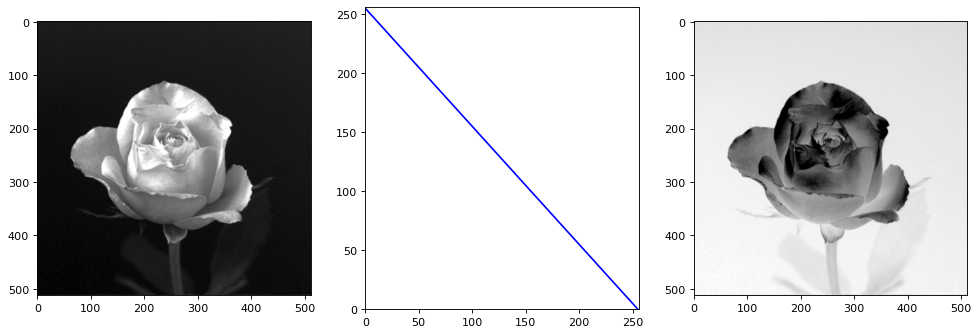

In [3]:
o = cv2.imread('rose.png')
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = 255 - i
pokazlut(o,lut);

> **Zadanie** obejrzyj negatywy obrazów `baboon.jpg` oraz `lotnicze.png`. Na wszystkich oglądanych obrazach, zwacaj uwagę na czytelność detali obrazu. Czy prezentacja obrazu w formie negatywu wpływa na czytelność elementów obrazów ?

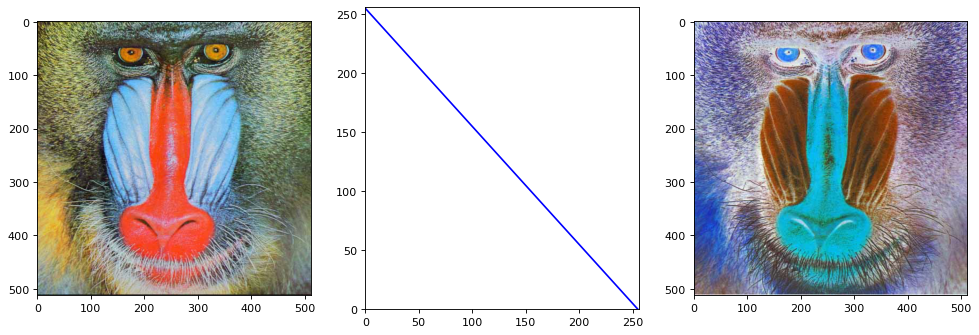

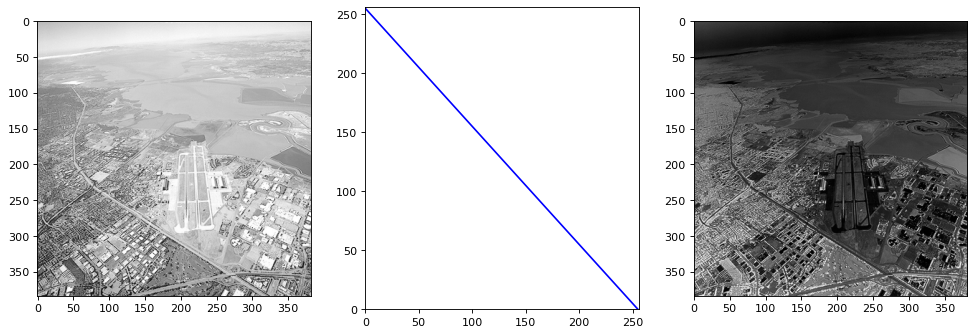

In [9]:
# miejsce na kod
o = cv2.imread('./ADOM/baboon.jpg')
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = 255 - i
pokazlut(o,lut);

o = cv2.imread('./ADOM/lotnicze.png')
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = 255 - i
pokazlut(o,lut);

Jedynymi z podstawowych operacji typu punktowego są **operacje arytmetyczne**: dodawanie, odejmowanie, mnożenie i dzielenie przez ustaloną liczbę. Dla uproszczenia eksperymentów utworzymy na początek funkcję generującą tablice korekcji dla tego typu operacji.

In [10]:
# generowanie tablicy lut dla operacji arytmetycznych
def lut_arytm(ile,mnoznik):
    lut = np.empty((1,256), np.uint8)
    for i in range(256):
         lut[0,i] = np.clip(i*mnoznik + ile, 0, 255) 
    return lut

Przy jej pomocy obejrzeć wynik operacji arytmetycznej.

In [12]:
# operacje arytmetyczne z LUT
o = cv2.imread('baboon.jpg')
ile = -10
mnoznik = 3
pokazlut(o,lut_arytm(ile,mnoznik));

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\core\src\matrix.cpp:405: error: (-215:Assertion failed) m.dims >= 2 in function 'cv::Mat::Mat'


> **Zadanie** Poeksperymentuj z różnymi wartościami zmiennych `ile` (także ujemnymi) oraz `mnoznik` (także z zakresu 0...1). Jakie efekty można uzyskać przy pomocy operacji artymetycznych ? Jakie widzisz niedoskonałości tych operacji ?

> **Zadanie** Poeksperymentuj z opracjami arytmetycznymi na obrazach `rice.tif`, `rtg.tif`, `lotnicze.png`. Czy i w jaki sposób można poprawić jakość tych zdjęć ?

> **Zadanie** Jak dotychczas omówione operacje (negatyw, dodawanie, odejmowanie, mnozenie i dzielenie) wpływaja na histogram obrazu? Wykonaj stosowne eksperymenty, obejrzyj histogramy przed i po wykonaniu operacji. Do wyświetlenia obrazu wraz z jego histogramem możesz wykorzystać funkcję `pokazhist` 

In [13]:
# miejsce na kod


## 1.3 Korekcja gamma i operacje oparte na histogramie

Korekcja **gamma**, pozwala na poprawe kontrastu obszarów jasnych kosztem ciemnych lub odwrotnie. Operacje te stosuje sie w sytuacji, gdy jasne obszary obrazu sa zbyt mało kontrastowe, zas ciemne nie odgrywaja wiekszej roli, lub odwrotnie. Na poczatek zostanie zdefiniowana funkcje generująca tablicę korekcji dla zadanego paramteru gamma. 

In [14]:
# tablica korekcji dla korekcji gamma
def lut_gamma(gamma): 
    lut = np.empty((1,256), np.uint8)
    for i in range(256):
        lut[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return lut

Dzięki niej możliwe jest wykonywania korekt obrazu opartych o korekcję gamma.

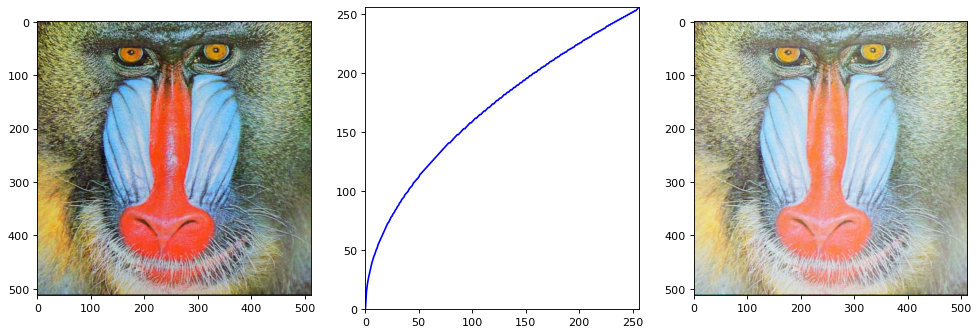

In [15]:
# korekcja gamma z LUT
gamma = 0.5
pokazlut(o,lut_gamma(gamma));

> **Zadanie** Poeksperymentuj z różnymi wartościami `gamma`. Porównaj rozjaśnianie i pociemnianie metoda koreksji gamma oraz operacjami arytmetycznymi.

> **Zadanie** Poeksperymentuj z opracjami arytmetycznymi na obrazach `rice.tif`, `rtg.tif`, `lotnicze.png`. Czy i w jaki sposób można poprawić jakość tych zdjęć korzystając z korekcji gamma ? Czym różnią się efekty korekcji gamma od wyników wcześniej przetestowanych operacji arytmetycznych.

Zdarza się, że obrazy mają zawężoną skalę jasności. Przykładowo, obraz może sprawiać wrazenie bladego przez to, ze brakuje w nim skrajnych odcieni szarosci – bliskich pełnej bieli i/lub czerni. W takim przypadku stosuje sie przekształcenie rozszerzajace skale odcieni szarosci wystepujacych w obrazie w ten sposób, by rozpoczynała sie od pełnej czerni (wartosc punktu = 0) az do pełnej bieli (wartośc punktu = 255). Operacja taka jest nazywana **rozciąganiem histogramu**. Takie
przekształcenie zwieksza kontrast obrazu przez zwiekszenie odstepów miedzy kolejnymi jasnosciami wystepujacymi w obrazie.

In [16]:
# tablica korekcji dla rozciągania histogramu
def lut_rozciag(wmin,wmax):
    lut = np.empty((1,256), np.uint8)
    for i in range(256):
        if i<wmin:
            lut[0,i] = 0
        elif i>wmax:
            lut[0,i] = 255
        else:
            lut[0,i] = int(float((i - wmin)*255)/float(wmax - wmin))
    return lut

min = 0  , max = 255


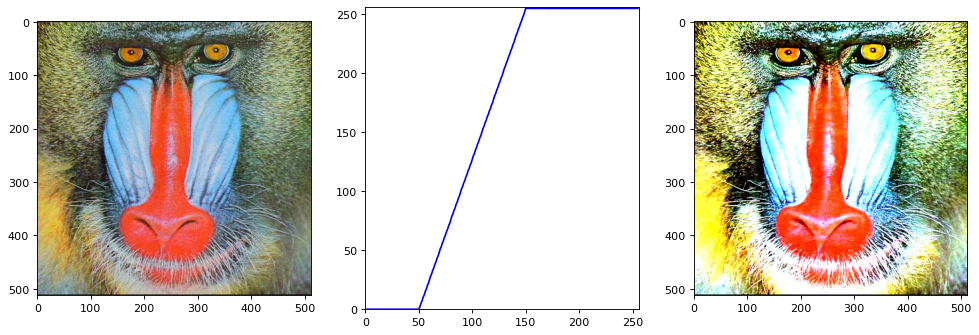

In [17]:
# rozciąganie histogramu z LUT
wmin = 50
wmax = 150
pokazlut(o,lut_rozciag(wmin,wmax));
print('min =',o.min()," , max =",o.max())

Rozciąganie histogramu umożliwia zwiększenie kontrastu obrazów o niskiej dynamice.

obraz oryginalny


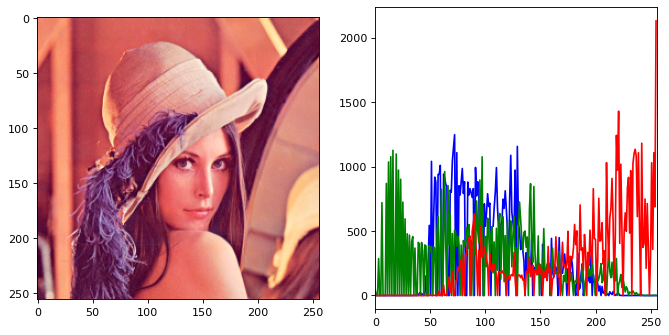

obraz o pogorszonej dynamice


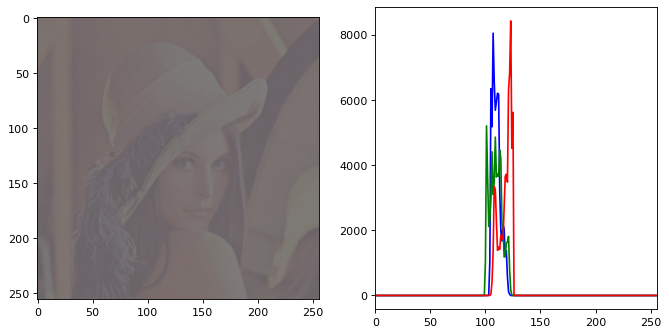

min= 100 max= 125
obraz skorygowany


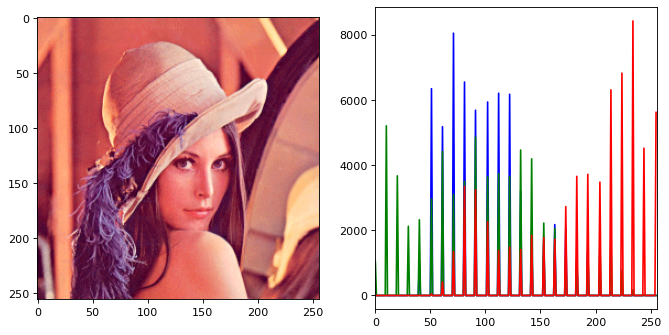

In [18]:
o = cv2.imread('lena.png')
# obraz oryginalny
print("obraz oryginalny")
pokazhist(o)
# obraz o niskiej dynamice
print("obraz o pogorszonej dynamice")
o2 = cv2.LUT(o,lut_arytm(100,0.1))
pokazhist(o2)
print("min=",o2.min(),"max=",o2.max())
# rozciągnięcie histogramu
print("obraz skorygowany")
o3 = cv2.LUT(o2,lut_rozciag(o2.min(),o2.max()))
pokazhist(o3)

> **Pytanie** Czym różni się obraz skorygowany (powyżej) od oryginalnego obrazu `lena` ?

**Wyrównywanie histogramu** polega na takim przetworzeniu obrazu wejściowego, by w efekcie powstał obraz o histogramie możliwie zbliżonym do wyrównanego tj. takiego w którym rozkład jasności jest równomierny. Funkcja `equalizeHist` realizuje wyrównywanie histogramu dla obrazu w skali szarości.


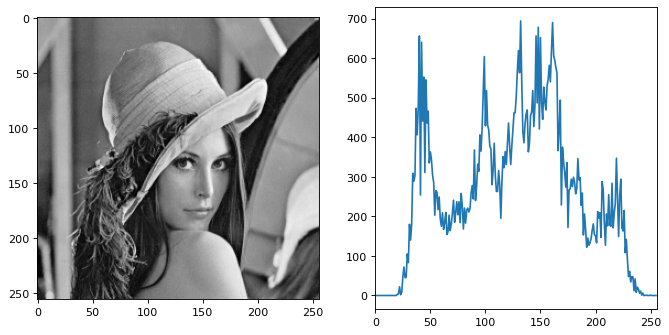

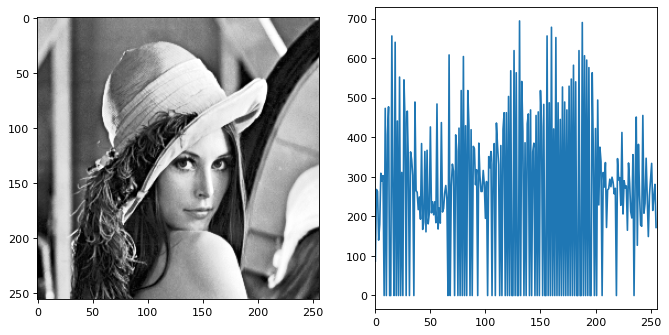

In [19]:
lena = cv2.imread('lena.png',0)
pokazhist(lena)
lena_wh = cv2.equalizeHist(lena)
pokazhist(lena_wh)

> **Zadanie** wykonaj wyrównywanie histogramu na obrazach `tire.tif` i `lotnicze.png`. Oceń rezultaty

> **Zadanie** Na podstawie opisu metody wyrównywania histogramu (materiały z wykładu lub informacje z Internetu) napisz funkcję, która dla zadanego obrazu (argumentu tej funkcji) wyznaczy tablicę korekcji operacji wyrównywania histogramu.

In [20]:
# miejsce na kod


## 1.4 Manipulowanie poziomami jasności, progowanie 

Progowanie jest najprostszą metoda konwersji obrazu skali szarości lub kolorowego w obraz binarny. Parametrem metody jest próg lub progi określające poziom jasności odcięcia. Mogą one być ustalane manualnie lub wyznaczane automatycznie.

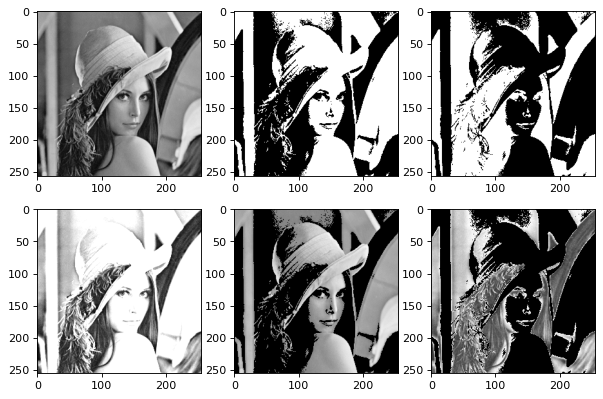

In [21]:
# progowanie obrazu w skali szarości
lena = cv2.imread('lena.png',0)
dol, gora = 127, 255
prg = np.zeros((256,256,5), np.uint8)
ret, prg[:,:,0] = cv2.threshold(lena,dol,gora,cv2.THRESH_BINARY)
ret, prg[:,:,1] = cv2.threshold(lena,dol,gora,cv2.THRESH_BINARY_INV)
ret, prg[:,:,2] = cv2.threshold(lena,dol,gora,cv2.THRESH_TRUNC)
ret, prg[:,:,3] = cv2.threshold(lena,dol,gora,cv2.THRESH_TOZERO)
ret, prg[:,:,4] = cv2.threshold(lena,dol,gora,cv2.THRESH_TOZERO_INV)

plt.figure(figsize=(9,6), dpi= 80)
plt.subplot(2,3,1)
pokaz(lena) 
for i in range(0,5):
    plt.subplot(2,3,i+2)
    pokaz(prg[:,:,i])

> **Pytanie** Czym róznią się poszczególne wyniki progowania dla tych samych wartości progowych ?

> **Zadanie** Poeksperymentuj z różnymi wartościami progowymi. Wyświetl wyniki dla wybranego rodzaju wyniku progowania dla róznych progów w formie macierzy obrazów (tak jak w powyższym przykładzie).

> **Zadanie** wykonaj progowanie dla obrazów `kalkulator.png` oraz `rice.tif` dobierz próg tak, by na obrazie były widoczne obiekty na obrazie oryginalnym.

Najbardziej znaną metodą automatycznego doboru wartości progowej jest tzw. metoda Otsu, optymalizująca wartość progową korzystając z miar statystycznych.

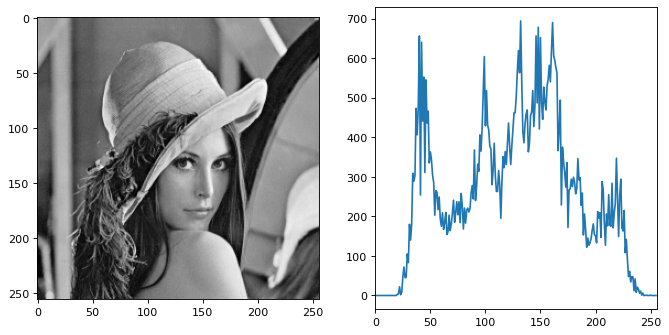

prog =  118.0


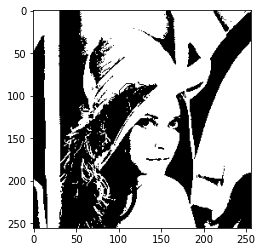

In [25]:
pokazhist(lena)
ret, otsu = cv2.threshold(lena,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("prog = ",ret)
pokaz(otsu)

> **Zadanie** Metody automatycznego doboru progu (w tym pokazana wyżej metoda Otsu) sprawdzają się najlepiej dla obrazów o histogramie bimodalnym. Obrazem takim jest obraz `dowels.png`. Powtórz powyższy przykład dla tego obrazu.

> **Zadanie** Znajdź samodzielnie metody realizujące pokazane wyżej operacje punktowe w pakiecie `scikit-image`

## 1.5 Segmentacja koloru

Obraz kolorowy składa się z pikseli będących wektorami składowych koloru. W modelu RGB są to składowe czerwona, zielona i niebieska. Piksele w danym obrazie barwnym tworzą chmurę punktów w przestrzeni barw. Zdefiniowana poniżej, funkcja `kolory_rgb` pokazuje obraz kolorowy oraz chmurę punktów w przestrzeni RGB. 

In [28]:
def kolory_rgb(obr):
    obr_rgb = cv2.cvtColor(obr, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(obr_rgb)
    fig = plt.figure(figsize=(10,5), dpi= 80)
    plt.subplot(1,2,1)
    pokaz(obr)  
    axis = fig.add_subplot(1,2, 2, projection="3d")
    kolory_pikseli = obr_rgb.reshape((np.shape(obr_rgb)[0]*np.shape(obr_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(kolory_pikseli)
    kolory_pikseli = norm(kolory_pikseli).tolist()
    axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=kolory_pikseli, marker=".")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")
    plt.show()
    

Przykład poniżej prezentuje przykładową chmurę punktów koloru dla prostego obrazu.

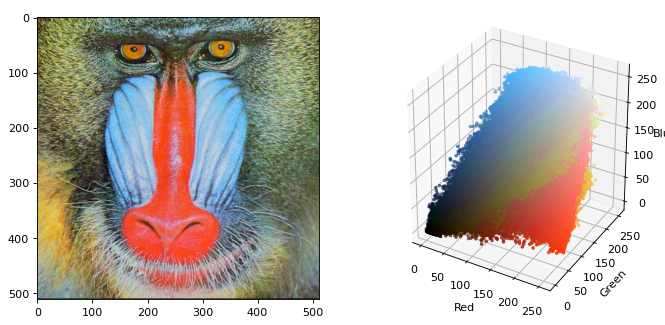

In [29]:
obr = cv2.imread('baboon.jpg')
kolory_rgb(obr)


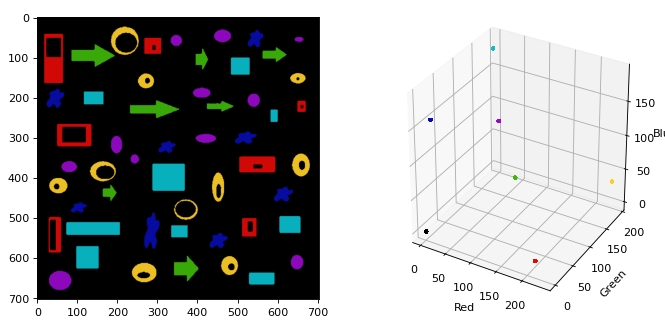

In [30]:
obr = cv2.imread('obiekty.png')
kolory_rgb(obr)


> **Zadanie** zobacz jak wyglądają chmury punktów dla innych obrazów kolorowych znajdujących się w katalogu roboczym

> **Zadanie** zobacz jak wyglądają chmury punktów dla innych obrazów kolorowych znajdujących się w katalogu roboczym

Segmentacja obrazu kolorowego przez progowanie wymaga podania zakresu kolorów, dla którym w docelowym obrazie binarnym zostaną przypisane wartości 1.  

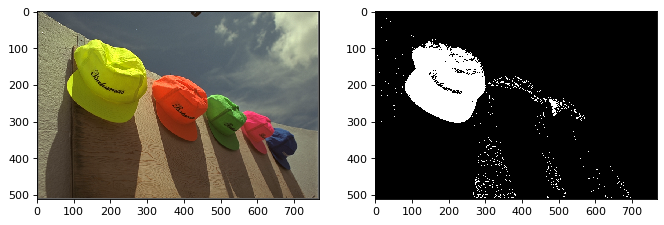

In [121]:
obr = cv2.imread('kodim03.png')
#BGR
dol = (0,90,80)
gora = (70,255,255)
bin = cv2.inRange(obr, dol, gora)
pokaz2(obr,bin)

> **Zadanie** Poeksperymentuj z innymi zakresami i innymi obrazami, spróbuje wyodrębnić z obrazów dobrze rozróżnialne obiekty. 

> **Zadanie** Wykonaj podobne eksperymenty ale wybierając zakresy w innych przestrzeniach kolorów.

In [1]:
# miejsce na kod


> **Przykłady:**
* https://realpython.com/python-opencv-color-spaces/
* https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
* https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

# 2. Operacje na wielu obrazach

## 2.1 Operacje arytmetyczne

Operacje punktowe na **dwóch** obrazach umożliwiają m.in. ich łączenie w jeden poprzez zmieszanie, wyznaczanie różnicy itp.
Przykład poniżej pokazuje sumowanie dwóch obrazów na dwa sposoby - modulo (obraz `s1`) oraz z przepełnieniem (obraz `s2`).

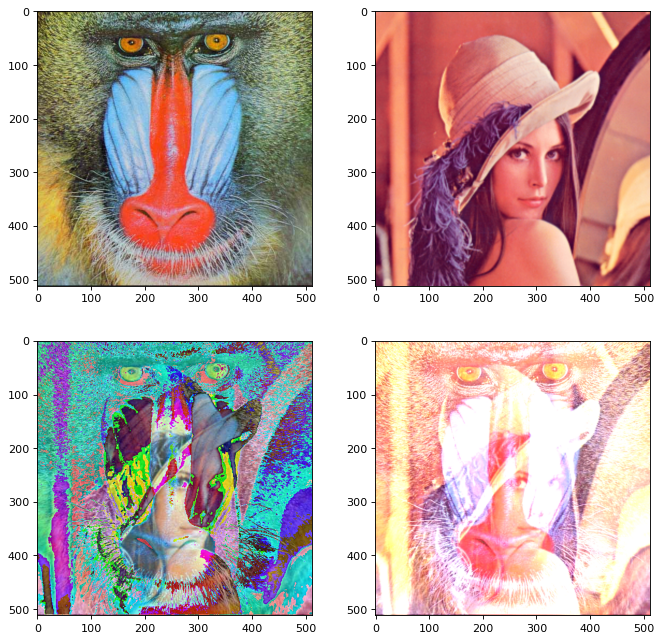

In [36]:
o1 = cv2.imread('baboon.jpg')
# funkcja imresize zmienia rozmiar obrazu
o2 = cv2.resize(cv2.imread('lena.png'),(512,512))
s1 = np.clip(o1 + o2, 0, 255)
s2 = cv2.add(o1,o2)
plt.figure(figsize=(10,10), dpi= 80)
plt.subplot(2,2,1)
pokaz(o1)
plt.subplot(2,2,2)
pokaz(o2)
plt.subplot(2,2,3)
pokaz(s1)
plt.subplot(2,2,4)
pokaz(s2)

> **Pytanie** Na czym polega różnica między dwoma powyższymi wynikami ?

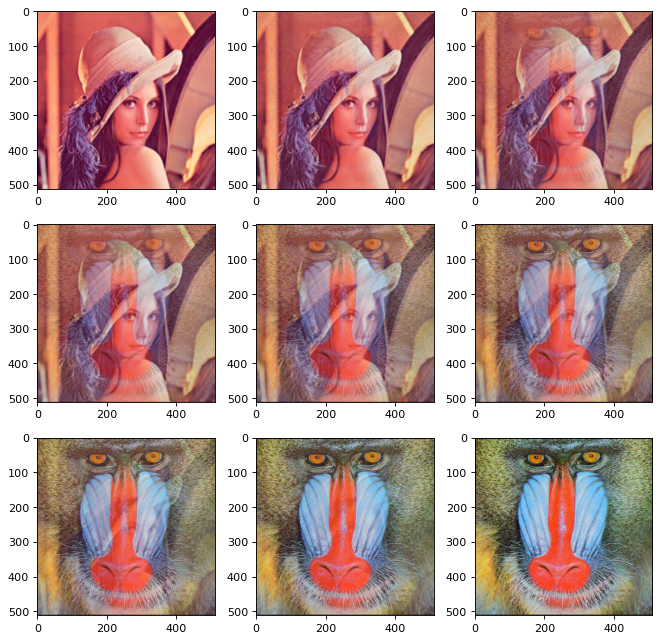

In [34]:

plt.figure(figsize=(10,10), dpi= 80)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    mieszanka = cv2.addWeighted(o1,i/8,o2,1-i/8,0)
    pokaz(mieszanka)


## 2.2 Ukrywanie informacji

Steganografia jest nauka o ukrywaniu informacji. Obrazy cyfrowe stanowią bardzo wygodny nośnik informacji ukrytej. Najprostszy sposób ukrycia informacji w obrazie wykorzystuje ograniczenia oka ludzkiego w rozróznianiu odcieni szarości i barw o zblizonych parametrach. Dla obrazów w skali szarości zdolność oka ludzkiego do rozrózniania sasiadujacych odcieni szarosci konczy sie na skali od czystej bieli do czystej czerni składajacej sie z około 80 odcieni szarości. Oznacza to, ze przy wiekszej liczbie posrednich odcieni szarosci nie jest mozliwe rozróznienie odcieni sasiadujacych na skali. Analogicznie sytuacja wygląda w przypadku składowych koloru obrazu kolorowego.

Poniższy przykład pokazuje kodowanie polegające na ukryciu jednego obrazu kolorowego w innym. Każdy z obrazów jest modyfikowany w ten sposób, że odrzucane są cztery najmniej znaczące bity każdej składowej. Następnie pozostałe najbardziej znaczące bity obrazu ukrywanego sa kodowane na zwolnionych czterech najmniej znaczących bitach obrazu - nośnika.

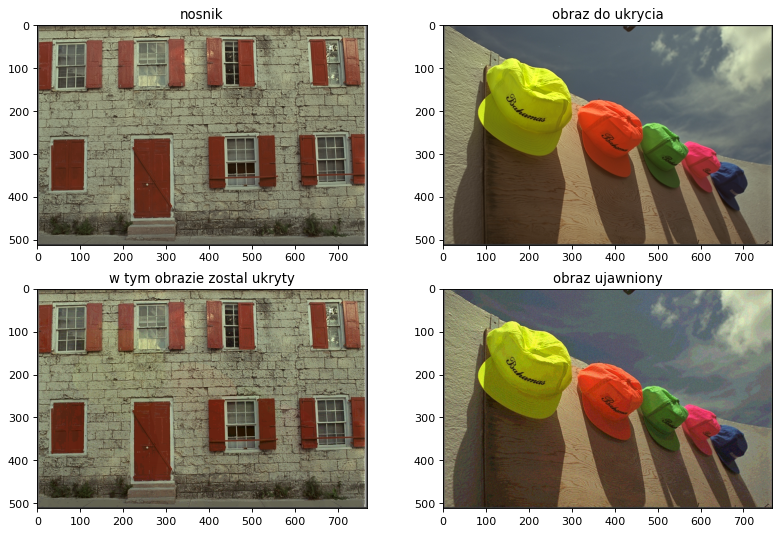

In [37]:
import random 
    
# Funkcja ukrywająca
def ukryj(img1,img2): 
    wyj = np.zeros((img1.shape[0] , img2.shape[1], 3), np.uint8) 
    for i in range(img2.shape[0]): 
        for j in range(img2.shape[1]): 
            for l in range(3): 
                # wycinamy bity
                v1 = format(img1[i][j][l], '08b') 
                v2 = format(img2[i][j][l], '08b') 
                # łączymy
                v3 = v1[:4] + v2[:4]  
                wyj[i][j][l]= int(v3, 2) 
    return wyj             
  
# Funkcja ujawniająca ukryty obraz
def ujawnij(img): 
    wyj = np.zeros((img.shape[0] , img.shape[1] , 3), np.uint8) 
    for i in range(img.shape[0]): 
        for j in range(img.shape[1]): 
            for l in range(3): 
                pom = format(img[i][j][l], '08b') 
                wyj[i][j][l]= int(pom[4:] + chr(random.randint(0, 1)+48) * 4, 2) 
    return wyj  

      
img1 = cv2.imread('kodim01.png') 
img2 = cv2.imread('kodim03.png') 

zakodowany = ukryj(img1,img2) 
odkodowany = ujawnij(zakodowany) 

plt.figure(figsize=(12,8),dpi = 80)
plt.subplot(2,2,1)   
pokaz(img1,"nosnik")
plt.subplot(2,2,2)   
pokaz(img2,"obraz do ukrycia")
plt.subplot(2,2,3)   
pokaz(zakodowany,"w tym obrazie zostal ukryty")
plt.subplot(2,2,4)   
pokaz(odkodowany,"obraz ujawniony")


> **Zadanie** Napisz funkcję, która będzie ukrywać obraz binarny (tj. w skali szarości o dwóch wartościach 0 i 255) na określonym bicie określonej składowej obrazu kolorowego - nośnika. Fukncja powinna posiadać cztery argumenty wejściowe: obraz nośnik, indeks składowej (0,1,2) i numer bitu (0,1,..7) na którym ukrywamy oraz obraz ukrywany. Dla sprawdzenia napisz także funkcję dekodującą, która powinna posiadać trzy argumenty: obraz w którym ukryto inny, indeks składowe i numer bitu, z którego nalezy odczytać ukryty obraz. 

## 2.3 Pseudokolorowanie

Pseudokolorowanie polega na konwersji obrazu w skali szarosci na obraz kolorowy w celu poprawy
jego czytelnosci. Jego celem jest nie tylko uatrakcyjnienie wyswietlanego obrazu, ale
takze zwiekszenie jego czytelnosci. To ostatnie jest zwiazane z faktem ograniczonej zdolnosci
oka ludzkiego do rozrózniania niewiele rózniacych sie jasnosci.

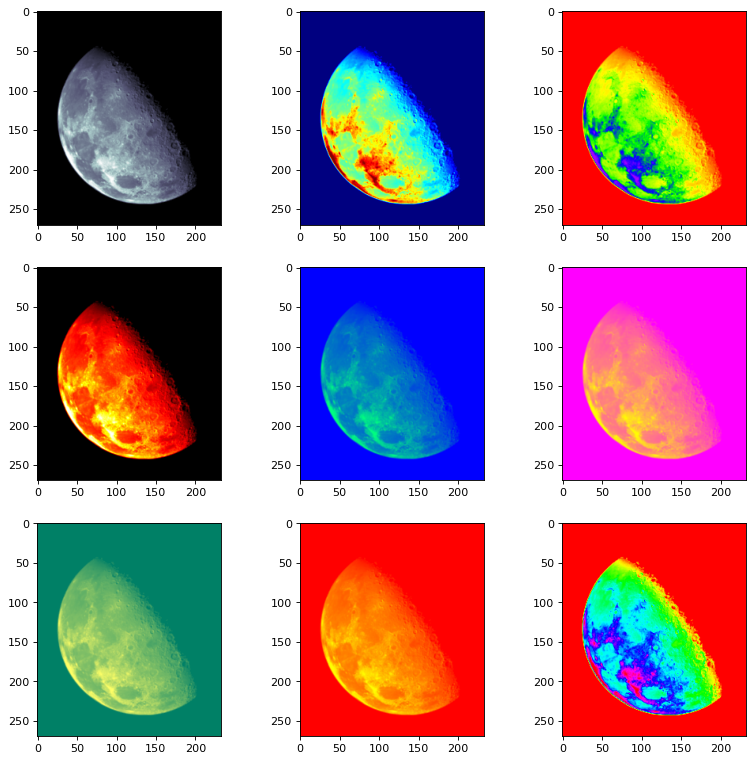

In [38]:
o = cv2.imread('moon.png',0)
mapykol = [ cv2.COLORMAP_BONE, cv2.COLORMAP_JET, cv2.COLORMAP_RAINBOW, cv2.COLORMAP_HOT, 
            cv2.COLORMAP_WINTER, cv2.COLORMAP_SPRING, cv2.COLORMAP_SUMMER, cv2.COLORMAP_AUTUMN, cv2.COLORMAP_HSV]
plt.figure(figsize=(12,12), dpi= 80)
for i, mkol in enumerate(mapykol):
    o_col = cv2.applyColorMap(o, mkol)
    plt.subplot(3,3,i+1)
    pokaz(o_col)

> **Pytanie** Zastosowanie których z tablic kolorów pozwala na lepsze rozróżnianie detali na obrazie, a których - gorsze ? Dlaczego ?

> **Zadanie** Utwórz i zastosuj własną tablicę kolorów.

---
---
Historia zmian:
* wersja pierwotna r.akad 20/21 na bazie PRiAD: 1.11.2020 (MI)